In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append('..')

gen_dir = '../generations/memo/fifty_fifty/split0'

In [3]:
from html import escape
from IPython.display import HTML

def _is_leaf(obj):
    """True if `obj` is not a list / tuple / set / dict."""
    return not isinstance(obj, (list, tuple, set, dict))
17
def _to_details(obj, title="Item", depth=0, auto_preleaf=False):
    """Recursively wrap `obj` in <details>/<summary>."""
    indent = " " * 4 * depth
    inner_html = ""

    # Decide how to render the current object's children
    if isinstance(obj, dict):
        # Dict → each key becomes a nested collapsible
        inner_html = "\n".join(
            _to_details(v, title=k, depth=depth + 1, auto_preleaf=auto_preleaf) for k, v in obj.items()
        )
        is_preleaf = all(_is_leaf(v) for v in obj.values())
    elif isinstance(obj, (list, tuple, set)):
        # Iterable → each element gets its own collapsible
        inner_html = "\n".join(
            _to_details(item, title=f"{title}-{i}", depth=depth + 1, auto_preleaf=auto_preleaf)
            for i, item in enumerate(obj, 1)
        )
        is_preleaf = all(_is_leaf(el) for el in obj)
    else:
        # show the title inline, then the value
        return (
            f"{indent}<div>"
            f"<strong>{escape(str(title))}</strong>: "
            f"{escape(str(obj))}"
            f"</div>"
        )

    # Wrap the generated inner HTML in a details block
    open_attr = " open" if (auto_preleaf and is_preleaf) else ""
    return (
        f"{indent}<details{open_attr}>\n"
        f"{indent}    <summary><strong>{escape(str(title))}</strong></summary>\n"
        f"{inner_html}\n"
        f"{indent}</details>"
    )

def show_collapsible(data, root_title="Root"):
    """Display a nested collapsible representation of `data`."""
    html = _to_details(data, title=root_title)
    return html


In [5]:
from dataclasses import asdict
import math
from datasets import load_dataset
from memorization import score_at_k, extract_answer, default_scoring_fn
import json
from tqdm.notebook import tqdm

datapoints = []
overall = {}
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    overall[freq] = []
    qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
    qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
    qa_ref_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_aug.parquet')['train']
    qa_ref_doc = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_doc.parquet')['train']
    print(qa_ref_aug)
    for i in tqdm(range(len(qa))):
        overall[freq].append([])
        datapoint = {}
        question = qa[i]['question']
        label = json.loads(qa[i]['possible_answers'])

        # qa
        answers = json.loads(qa[i]['model_predictions'])    
        # qa_aug/max/avg_over...    
        aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
        aug_completions = json.loads(qa_aug[i]['model_completions'])

        # qa_ref_aug/max_avg_over...
        ref_aug_answers = json.loads(qa_ref_aug[i]['model_self_augmented_predictions'])
        ref_aug_completions = json.loads(qa_ref_aug[i]['model_completions'])
 
        # qa straight
        ext_answers = list(map(extract_answer, answers))
        datapoint['question'] = question
        datapoint['label'] = label
        datapoint['s_pop'] = qa[i]['s_pop']
        datapoint['qa/score@1'] = asdict(score_at_k(label, ext_answers, default_scoring_fn))


        # get a point for ref aug
        if qa_aug[i]['prefix_before_answer_extraction_success']:
            max_doc_ref_pass_at_1 = -math.inf            
            for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
                ext_ref_answers = list(map(extract_answer, ref_answers))
                score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
                if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                    max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                    datapoint['qa_ref/prefix/score@1'] = asdict(score_at_1_ref_of_doc)
                    datapoint['qa_ref/prefix/doc_index'] = l
                    datapoint['qa_ref/prefix/doc'] = qa_aug[i]['s_docs'][l]
                    datapoint['qa_ref/prefix/ref'] = qa_aug[i]['prefix_before_answer']
        else:
            datapoint['qa_ref/prefix/score@1'] = None
        
        # get a point for ref doc
        max_doc_ref_pass_at_1 = -math.inf

        for l, ref_answers in enumerate(json.loads(qa_ref_doc[i]['model_ref_doc_augmented_predictions'])):
            ext_ref_answers = list(map(extract_answer, ref_answers))
            score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
            if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                datapoint['qa_ref/doc/score@1'] = asdict(score_at_1_ref_of_doc)
                datapoint['qa_ref/doc/doc_index'] = l
                datapoint['qa_ref/doc/doc'] = qa_ref_doc[i]['s_docs'][l]['text'][:2048*4]

        # get points for self-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(aug_answers, aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/self/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/self/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/self/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/self/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/self/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/self/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/self/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/self/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        
        # get points for prefix-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(ref_aug_answers, ref_aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/ref/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/ref/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/ref/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/ref/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/ref/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/ref/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/ref/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/ref/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        datapoints.append(datapoint)

KeyboardInterrupt: 

In [5]:
# cnt = 0
# for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
#     qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
#     qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
#     for i in tqdm(range(len(qa))):
#         answers = json.loads(qa[i]['model_predictions'])
#         aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
#         aug_completions = json.loads(qa_aug[i]['model_completions'])
#         question = qa[i]['question']
#         label = json.loads(qa[i]['possible_answers'])
#         if qa_aug[i]['prefix_before_answer_extraction_success']:
#             max_doc_ref_pass_at_1 = -math.inf
#             for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
#                 ext_ref_answers = list(map(extract_answer, ref_answers))
#                 score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
#                 if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
#                     max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
#                     datapoints[cnt]['qa_aug/ref/pass@1'] = asdict(score_at_1_ref_of_doc)
#                     datapoints[cnt]['qa_aug/ref/doc_index'] = l
#                     datapoints[cnt]['qa_aug/ref/doc'] = qa[i]['s_docs'][l]
#                     datapoints[cnt]['qa_aug/ref/ref'] = qa_aug[i]['prefix_before_answer']
#         else:
#             datapoint[i]['qa_aug/ref/pass@1'] = None
#         cnt += 1

In [6]:
len(overall['100000_to_inf'])

81

In [7]:
with open('data/0611_memo/memo_results.html', 'wt') as f:
    print(show_collapsible(overall), file=f)

with open('data/0611_memo/pass_at_1.json', 'wt') as f:
    print(json.dumps(datapoints, indent=4), file=f)

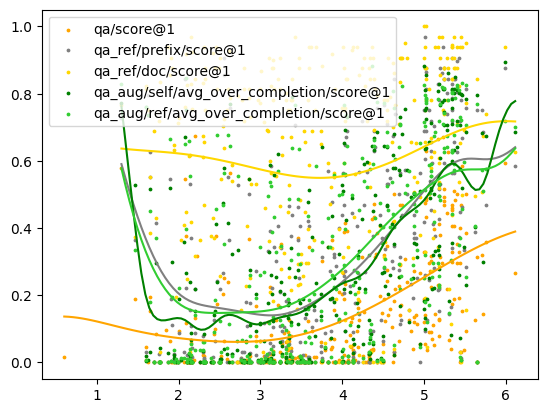

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
    'qa_aug/self/avg_over_completion/score@1': {
        'plot' : {
            'color': 'green'
        },
    }, 
    # 'qa_aug/self/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'blue'
    #     },
    # },
    'qa_aug/ref/avg_over_completion/score@1': {
        'plot' : {
            'color': 'limegreen'
        },
    }, 
    # 'qa_aug/ref/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'cyan'
    #     },
    # },

}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend()
plt.show()

# Why does full doc fail?

In [9]:
qa_aug[0]['model_ref_augmented_predictions']
qa_aug[0]['model_ref_augmented_predictions']

'[["Sucre <thought>La Paz is the political and administrative capital</thought> but Sucre is the constitutional capital of Bolivia <answer>Sucre</answer>.", "<thought> The constitutional capital of Bolivia is Sucre. </thought> <answer> Sucre </answer>", "<thought> The constitutional capital of Bolivia is Sucre. </thought> <answer> Sucre</answer>", "<thought> The constitutional capital of Bolivia is Sucre. However, I\'m not sure whether this detail was among the information previously stored. </thought> \\n<answer> Sucre", "<thought>That information about Bolivia seems relevant but doesn\'t directly answer the question about its capital. Since the question asks for the capital and not the seat of government or constitutional capital, focusing on the primary administrative center would give a straight answer.</thought> The capital of Bolivia is <answer>Sucre</answer>.", "<thought> Bolivia\'s constitutional capital is Sucre </thought> <answer> Sucre </answer>", "<thought>Based on the info

In [43]:
dat_file = load_dataset('parquet', data_files=f'{gen_dir}/0_to_1000/dev.decon.wikilinked.qa.ref_doc.parquet')['train']
print(dat_file[-1]['question'])
print(dat_file[-1]['possible_answers'])
json.loads(dat_file[-1]['model_ref_doc_augmented_predictions'])

Who was the producer of Pizza?
["Alain Bashung", "Alain Claude Baschung"]


[['<thought>Upon recalling that "Pizza" is the third album by French rocker Alain Bashung and given the mention of Philips Records in the provided information, the producer of "Pizza" would likely be associated with this record production through the label. <thought> Given there is no explicit mention of a producer by name in the provided information, and focusing on the context which names Alain Bashung as the primary artist and Philips Records as the label, a reasonable conclusion without additional specific data might be that the producer was someone who worked under the aegis of Philips Records during the time of "Pizza"s release. <thought> However, to provide a definitive answer, more specific information about the production team associated with "Pizza" would be needed. <answer> Philips Records Producer',
  '<thought>Given the detailed information about Alain Bashung and his album "Pizza"...</thought> <answer>Alain Bashung</answer>',
  '<thought>Alain Bashung</thought> was the pr

# qa performance after training

In [ ]:
from dataclasses import asdict
import math
from datasets import load_dataset
from memorization import score_at_k, extract_answer, default_scoring_fn, extract_thought
import json
from tqdm.notebook import tqdm

datapoints = []
overall = {}
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    overall[freq] = []
    qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
    qa_epoch_1 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_1.parquet')['train']
    qa_epoch_2 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_2.parquet')['train']
    qa_epoch_3 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_3.parquet')['train']
    qa_epoch_4 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_4.parquet')['train']
    qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_5.parquet')['train']
    qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
    qa_ref_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_aug.parquet')['train']
    qa_ref_doc = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_doc.parquet')['train']
    print(qa_ref_aug)
    for i in tqdm(range(len(qa))):
        overall[freq].append([])
        datapoint = {}
        question = qa[i]['question']
        label = json.loads(qa[i]['possible_answers'])

        # qa
        answers = json.loads(qa[i]['model_predictions'])    
        answers_epoch_1 = json.loads(qa_epoch_1[i]['model_predictions'])    
        answers_epoch_2 = json.loads(qa_epoch_2[i]['model_predictions'])    
        answers_epoch_3 = json.loads(qa_epoch_3[i]['model_predictions'])    
        answers_epoch_4 = json.loads(qa_epoch_4[i]['model_predictions'])    
        answers_epoch_5 = json.loads(qa_epoch_5[i]['model_predictions'])    
        
        # qa_aug/max/avg_over...    
        aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
        aug_completions = json.loads(qa_aug[i]['model_completions'])

        # qa_ref_aug/max_avg_over...
        ref_aug_answers = json.loads(qa_ref_aug[i]['model_self_augmented_predictions'])
        ref_aug_completions = json.loads(qa_ref_aug[i]['model_completions'])
 
        # qa straight
        ext_answers = list(map(extract_answer, answers))
        datapoint['question'] = question
        datapoint['label'] = label
        datapoint['s_pop'] = qa[i]['s_pop']
        datapoint['qa/score@1'] = asdict(score_at_k(label, ext_answers, default_scoring_fn))

        ext_answers_epoch_1 = list(map(extract_answer, answers_epoch_1))
        datapoint['qa/epoch_1/score@1'] = asdict(score_at_k(label, ext_answers_epoch_1, default_scoring_fn))
        ext_answers_epoch_2 = list(map(extract_answer, answers_epoch_2))
        datapoint['qa/epoch_2/score@1'] = asdict(score_at_k(label, ext_answers_epoch_2, default_scoring_fn))
        ext_answers_epoch_3 = list(map(extract_answer, answers_epoch_3))
        datapoint['qa/epoch_3/score@1'] = asdict(score_at_k(label, ext_answers_epoch_3, default_scoring_fn))
        ext_answers_epoch_4 = list(map(extract_answer, answers_epoch_4))
        datapoint['qa/epoch_4/score@1'] = asdict(score_at_k(label, ext_answers_epoch_4, default_scoring_fn))
        ext_answers_epoch_5 = list(map(extract_answer, answers_epoch_5))
        datapoint['qa/epoch_5/score@1'] = asdict(score_at_k(label, ext_answers_epoch_5, default_scoring_fn))


        # get a point for ref aug
        if qa_aug[i]['prefix_before_answer_extraction_success']:
            max_doc_ref_pass_at_1 = -math.inf            
            for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
                ext_ref_answers = list(map(extract_answer, ref_answers))
                score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
                if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                    max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                    datapoint['qa_ref/prefix/score@1'] = asdict(score_at_1_ref_of_doc)
                    datapoint['qa_ref/prefix/doc_index'] = l
                    datapoint['qa_ref/prefix/doc'] = qa_aug[i]['s_docs'][l]
                    datapoint['qa_ref/prefix/ref'] = qa_aug[i]['prefix_before_answer']
        else:
            datapoint['qa_ref/prefix/score@1'] = None
        
        # get a point for ref doc
        max_doc_ref_pass_at_1 = -math.inf

        for l, ref_answers in enumerate(json.loads(qa_ref_doc[i]['model_ref_doc_augmented_predictions'])):
            ext_ref_answers = list(map(extract_answer, ref_answers))
            score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
            if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                datapoint['qa_ref/doc/score@1'] = asdict(score_at_1_ref_of_doc)
                datapoint['qa_ref/doc/doc_index'] = l
                datapoint['qa_ref/doc/doc'] = qa_ref_doc[i]['s_docs'][l]['text'][:2048*4]

        # get points for self-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(aug_answers, aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/self/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/self/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/self/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/self/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/self/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/self/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/self/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/self/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        
        # get points for prefix-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(ref_aug_answers, ref_aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/ref/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/ref/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/ref/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/ref/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/ref/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/ref/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/ref/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/ref/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        datapoints.append(datapoint)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 97
})


  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 90
})


  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 91
})


  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 81
})


  0%|          | 0/81 [00:00<?, ?it/s]

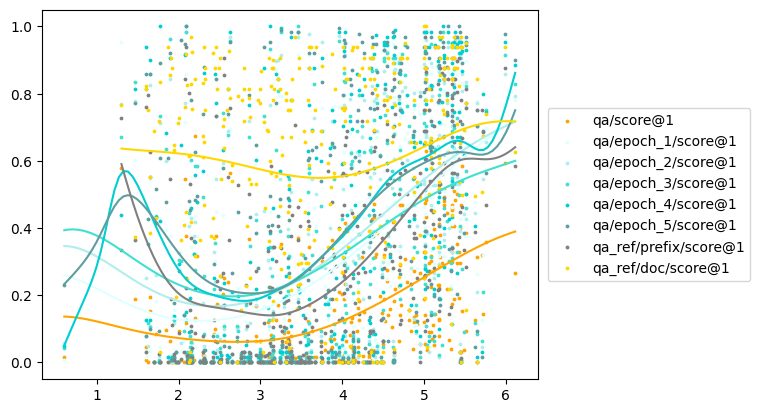

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/epoch_1/score@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/epoch_2/score@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/epoch_3/score@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/epoch_4/score@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/epoch_5/score@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
    # 'qa_aug/self/avg_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'green'
    #     },
    # }, 
    # 'qa_aug/self/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'blue'
    #     },
    # },
    # 'qa_aug/ref/avg_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'limegreen'
    #     },
    # }, 
    # 'qa_aug/ref/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'cyan'
    #     },
    # },

}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

# 1000_to_10000

In [ ]:
freq = '1000_to_10000'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_5.parquet')['train']
i=0
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(extract_answer(pred))

Who is the father of Robert, King of Naples?
['Charles II of Naples']
Charles II of Naples
Amalric II of Jerusalem
Roger II of Sicily
Frederick II
King Louis VII
Adémas I of Sicily
Hugh II of Sicily
Raymond V of Toulouse

Andronicus I Comnenus

Guillauming of Tusculum
Louis VII of France
Hugh of Normandy
Charles II of Naples
Charles of Anjou
William II of Sicily
Charles II


Lothair III
Louis VII
Charles VI of France
Eleanor of Aquitaine
Charles I of Sicily
Roger II of Sicily
Charles I of Naples

Charles VI of France
Roger II of Sicily
Charles II of Naples
Eleanor of Aquitaine

Louis VII of France
Charles Martel of Anjou
King Robert
Charles II of Naples

Louis VII
Bernard of France

Frederick II of Sicily
Guiscard
Henry the Great

Charles II of Naples
Charles I of Anjou
Charles II of Naples
Charles II of Naples
Amalric I of Jerusalem
Charles II of Naples
Frederick II of Sicily
Charles II of Naples
Frederick II of Sicily
Pope Innocent VI
Charles II of Naples
Albert III of Byzantium
Ramo

In [22]:
freq = '1000_to_10000'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
i=0
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(extract_answer(pred))

Who is the father of Robert, King of Naples?
['Charles II of Naples']
Roger II of Sicily



Charles d'Anjou


 William I 


Charles I of Anjou

Charles of Anjou

Frederick II of Hohenstaufen
William the gorgeous


Charles V of Naples
Robert Guiscard
Roger II of Sicily




 Hugh of San Germano



Alfonso III of Aragon

William the Easy
William II
Roger II



Frederick II

Charles of Durazzo




Frederick II

Charles d'Anjou



Charlemagne
Roger II of Sicily



Charles VI of France




Charlemagne


Roger II of Sicily


# 100000 to inf

In [37]:
freq = '100000_to_inf'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_5.parquet')['train']
i=7
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(extract_answer(pred))

What is the capital of North Macedonia?
['Skopje']
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Republic of Macedonia
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Sofia
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Sofia
Skopje
Skopje
Štip Municipality
Skopje
Skopje
Skopje
Sofia
Skopje

Sofia
Skopje
Skopje
SKUPČA
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Sofia
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje
Skopje


In [38]:
freq = '100000_to_inf'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
i=7
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(extract_answer(pred))

What is the capital of North Macedonia?
['Skopje']
Skopje
Skopje





Skopje
Skopje
Skopje

Skopje
Skopje
 Skopje

Skopje
Skopje

Skopje
Skopje


Oh, I meant Skopje



Pretoria

Skopje


Skopje



Skopje
Skopje

Skopje
Skopje

Skopje

Skopje
Skopje
Skopje
Skopje




Skopje





Skopje




Skopje



In [40]:
freq = '100000_to_inf'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
i=7
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(pred)

What is the capital of North Macedonia?
['Skopje']
<br><thought>North Macedonia's capital is Skopje.</thought><answer>Skopje</answer>
<thought>I know that the capital of North Macedonia is Skopje.</thought> <answer>Skopje</answer>
<thought>North Macedonia is a country in Southeast Europe; its capital is Skopje. <thought> The answer is Skopje.
<thought>North Macedonia was previously known as the Republic of Macedonia and was a part of Yugoslavia until gaining independence in 1991. <thought>Its capital is Skopje. <answer>Skopje
<thought>North Macedonia is one of the new European countries that emerged after the breakup of Yugoslavia. After gaining independence in 1991, it went by the name of Macedonia until 2019 when it changed its name to North Macedonia to avoid any confusion with the neighboring Greek region of Macedonia.</thought> <answer>Skopje
<thought> North Macedonia is a country in Southeastern Europe that gained its independence in 1991, succeeding the Socialist Republic of Mac

# QA performance on train (both qa and wiki) and dev2 (neither qa nor wiki)

In [35]:
from dataclasses import asdict
import math
from datasets import load_dataset
from memorization import score_at_k, extract_answer, default_scoring_fn
import json
from tqdm.notebook import tqdm
import numpy as np

datapoints = []
overall = {}

def nonempty(ans):
    return {'mean' : np.mean([len(a) > 0 for a in ans])}

for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    overall[freq] = []
    qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
    qa_epoch_1 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_1.parquet')['train']
    qa_epoch_2 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_2.parquet')['train']
    qa_epoch_3 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_3.parquet')['train']
    qa_epoch_4 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_4.parquet')['train']
    qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_5.parquet')['train']
    qa_epoch_9 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_9.parquet')['train']
    qa_epoch_15 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_15.parquet')['train']
    qa_epoch_20 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_20.parquet')['train']
    qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
    qa_ref_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_aug.parquet')['train']
    qa_ref_doc = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_doc.parquet')['train']

    train_qa_epoch_1 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_1.parquet')['train']
    train_qa_epoch_2 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_2.parquet')['train']
    train_qa_epoch_3 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_3.parquet')['train']
    train_qa_epoch_4 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_4.parquet')['train']
    train_qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_5.parquet')['train']
    train_qa_epoch_9 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_9.parquet')['train']
    train_qa_epoch_15 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_15.parquet')['train']
    train_qa_epoch_20 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_20.parquet')['train']

    dev2_qa_epoch_1 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_1.parquet')['train']
    dev2_qa_epoch_2 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_2.parquet')['train']
    dev2_qa_epoch_3 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_3.parquet')['train']
    dev2_qa_epoch_4 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_4.parquet')['train']
    dev2_qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_5.parquet')['train']
    dev2_qa_epoch_9 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_9.parquet')['train']
    dev2_qa_epoch_15 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_15.parquet')['train']
    dev2_qa_epoch_20 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_20.parquet')['train']

    print(qa_ref_aug)
    for i in tqdm(range(len(qa))):
        overall[freq].append([])
        datapoint = {}
        question = qa[i]['question']
        label = json.loads(qa[i]['possible_answers'])

        # qa
        answers = json.loads(qa[i]['model_predictions'])    
        answers_epoch_1 = json.loads(qa_epoch_1[i]['model_predictions'])    
        answers_epoch_2 = json.loads(qa_epoch_2[i]['model_predictions'])    
        answers_epoch_3 = json.loads(qa_epoch_3[i]['model_predictions'])    
        answers_epoch_4 = json.loads(qa_epoch_4[i]['model_predictions'])    
        answers_epoch_5 = json.loads(qa_epoch_5[i]['model_predictions'])    
        answers_epoch_9 = json.loads(qa_epoch_9[i]['model_predictions'])    
        answers_epoch_15 = json.loads(qa_epoch_15[i]['model_predictions'])    
        answers_epoch_20 = json.loads(qa_epoch_20[i]['model_predictions'])    
        train_answers_epoch_1 = json.loads(train_qa_epoch_1[i]['model_predictions'])    
        train_answers_epoch_2 = json.loads(train_qa_epoch_2[i]['model_predictions'])    
        train_answers_epoch_3 = json.loads(train_qa_epoch_3[i]['model_predictions'])    
        train_answers_epoch_4 = json.loads(train_qa_epoch_4[i]['model_predictions'])    
        train_answers_epoch_5 = json.loads(train_qa_epoch_5[i]['model_predictions'])    
        train_answers_epoch_9 = json.loads(train_qa_epoch_9[i]['model_predictions'])    
        train_answers_epoch_15 = json.loads(train_qa_epoch_15[i]['model_predictions'])    
        train_answers_epoch_20 = json.loads(train_qa_epoch_20[i]['model_predictions'])    
        dev2_answers_epoch_1 = json.loads(dev2_qa_epoch_1[i]['model_predictions'])    
        dev2_answers_epoch_2 = json.loads(dev2_qa_epoch_2[i]['model_predictions'])    
        dev2_answers_epoch_3 = json.loads(dev2_qa_epoch_3[i]['model_predictions'])    
        dev2_answers_epoch_4 = json.loads(dev2_qa_epoch_4[i]['model_predictions'])    
        dev2_answers_epoch_5 = json.loads(dev2_qa_epoch_5[i]['model_predictions'])    
        dev2_answers_epoch_9 = json.loads(dev2_qa_epoch_9[i]['model_predictions'])    
        dev2_answers_epoch_15 = json.loads(dev2_qa_epoch_15[i]['model_predictions'])    
        dev2_answers_epoch_20 = json.loads(dev2_qa_epoch_20[i]['model_predictions'])    
        
        # qa_aug/max/avg_over...    
        aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
        aug_completions = json.loads(qa_aug[i]['model_completions'])

        # qa_ref_aug/max_avg_over...
        ref_aug_answers = json.loads(qa_ref_aug[i]['model_self_augmented_predictions'])
        ref_aug_completions = json.loads(qa_ref_aug[i]['model_completions'])
 
        # qa straight
        ext_answers = list(map(extract_answer, answers))
        datapoint['question'] = question
        datapoint['label'] = label
        datapoint['s_pop'] = qa[i]['s_pop']
        datapoint['qa/score@1'] = asdict(score_at_k(label, ext_answers, default_scoring_fn))
        datapoint['qa/format@1'] = nonempty(ext_answers)

        ext_answers_epoch_1 = list(map(extract_answer, answers_epoch_1))
        datapoint['qa/epoch_1/score@1'] = asdict(score_at_k(label, ext_answers_epoch_1, default_scoring_fn))
        datapoint['qa/epoch_1/format@1'] = nonempty(ext_answers_epoch_1)
        ext_answers_epoch_2 = list(map(extract_answer, answers_epoch_2))
        datapoint['qa/epoch_2/score@1'] = asdict(score_at_k(label, ext_answers_epoch_2, default_scoring_fn))
        datapoint['qa/epoch_2/format@1'] = nonempty(ext_answers_epoch_2)
        ext_answers_epoch_3 = list(map(extract_answer, answers_epoch_3))
        datapoint['qa/epoch_3/score@1'] = asdict(score_at_k(label, ext_answers_epoch_3, default_scoring_fn))
        datapoint['qa/epoch_3/format@1'] = nonempty(ext_answers_epoch_3)
        ext_answers_epoch_4 = list(map(extract_answer, answers_epoch_4))
        datapoint['qa/epoch_4/score@1'] = asdict(score_at_k(label, ext_answers_epoch_4, default_scoring_fn))
        datapoint['qa/epoch_4/format@1'] = nonempty(ext_answers_epoch_4)
        ext_answers_epoch_5 = list(map(extract_answer, answers_epoch_5))
        datapoint['qa/epoch_5/score@1'] = asdict(score_at_k(label, ext_answers_epoch_5, default_scoring_fn))
        datapoint['qa/epoch_5/format@1'] = nonempty(ext_answers_epoch_5)
        ext_answers_epoch_9 = list(map(extract_answer, answers_epoch_9))
        datapoint['qa/epoch_9/score@1'] = asdict(score_at_k(label, ext_answers_epoch_9, default_scoring_fn))
        datapoint['qa/epoch_9/format@1'] = nonempty(ext_answers_epoch_9)
        ext_answers_epoch_15 = list(map(extract_answer, answers_epoch_15))
        datapoint['qa/epoch_15/score@1'] = asdict(score_at_k(label, ext_answers_epoch_15, default_scoring_fn))
        datapoint['qa/epoch_15/format@1'] = nonempty(ext_answers_epoch_15)
        ext_answers_epoch_20 = list(map(extract_answer, answers_epoch_20))
        datapoint['qa/epoch_20/score@1'] = asdict(score_at_k(label, ext_answers_epoch_20, default_scoring_fn))
        datapoint['qa/epoch_20/format@1'] = nonempty(ext_answers_epoch_20)


        train_label = json.loads(train_qa_epoch_1[i]['possible_answers'])
        ext_train_answers_epoch_1 = list(map(extract_answer, train_answers_epoch_1))
        datapoint['qa/train/epoch_1/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_1, default_scoring_fn))
        datapoint['qa/train/epoch_1/format@1'] = nonempty(ext_train_answers_epoch_1)
        ext_train_answers_epoch_2 = list(map(extract_answer, train_answers_epoch_2))
        datapoint['qa/train/epoch_2/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_2, default_scoring_fn))
        datapoint['qa/train/epoch_2/format@1'] = nonempty(ext_train_answers_epoch_2)
        ext_train_answers_epoch_3 = list(map(extract_answer, train_answers_epoch_3))
        datapoint['qa/train/epoch_3/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_3, default_scoring_fn))
        datapoint['qa/train/epoch_3/format@1'] = nonempty(ext_train_answers_epoch_3)
        ext_train_answers_epoch_4 = list(map(extract_answer, train_answers_epoch_4))
        datapoint['qa/train/epoch_4/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_4, default_scoring_fn))
        datapoint['qa/train/epoch_4/format@1'] = nonempty(ext_train_answers_epoch_4)
        ext_train_answers_epoch_5 = list(map(extract_answer, train_answers_epoch_5))
        datapoint['qa/train/epoch_5/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_5, default_scoring_fn))
        datapoint['qa/train/epoch_5/format@1'] = nonempty(ext_train_answers_epoch_5)
        ext_train_answers_epoch_9 = list(map(extract_answer, train_answers_epoch_9))
        datapoint['qa/train/epoch_9/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_9, default_scoring_fn))
        datapoint['qa/train/epoch_9/format@1'] = nonempty(ext_train_answers_epoch_9)
        ext_train_answers_epoch_15 = list(map(extract_answer, train_answers_epoch_15))
        datapoint['qa/train/epoch_15/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_15, default_scoring_fn))
        datapoint['qa/train/epoch_15/format@1'] = nonempty(ext_train_answers_epoch_15)
        ext_train_answers_epoch_20 = list(map(extract_answer, train_answers_epoch_20))
        datapoint['qa/train/epoch_20/score@1'] = asdict(score_at_k(train_label, ext_train_answers_epoch_20, default_scoring_fn))
        datapoint['qa/train/epoch_20/format@1'] = nonempty(ext_train_answers_epoch_20)

        dev2_label = json.loads(dev2_qa_epoch_1[i]['possible_answers'])
        ext_dev2_answers_epoch_1 = list(map(extract_answer, dev2_answers_epoch_1))
        datapoint['qa/dev2/epoch_1/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_1, default_scoring_fn))
        datapoint['qa/dev2/epoch_1/format@1'] = nonempty(ext_dev2_answers_epoch_1)
        ext_dev2_answers_epoch_2 = list(map(extract_answer, dev2_answers_epoch_2))
        datapoint['qa/dev2/epoch_2/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_2, default_scoring_fn))
        datapoint['qa/dev2/epoch_2/format@1'] = nonempty(ext_dev2_answers_epoch_2)
        ext_dev2_answers_epoch_3 = list(map(extract_answer, dev2_answers_epoch_3))
        datapoint['qa/dev2/epoch_3/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_3, default_scoring_fn))
        datapoint['qa/dev2/epoch_3/format@1'] = nonempty(ext_dev2_answers_epoch_3)
        ext_dev2_answers_epoch_4 = list(map(extract_answer, dev2_answers_epoch_4))
        datapoint['qa/dev2/epoch_4/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_4, default_scoring_fn))
        datapoint['qa/dev2/epoch_4/format@1'] = nonempty(ext_dev2_answers_epoch_4)
        ext_dev2_answers_epoch_5 = list(map(extract_answer, dev2_answers_epoch_5))
        datapoint['qa/dev2/epoch_5/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_5, default_scoring_fn))
        datapoint['qa/dev2/epoch_5/format@1'] = nonempty(ext_dev2_answers_epoch_5)
        ext_dev2_answers_epoch_9 = list(map(extract_answer, dev2_answers_epoch_9))
        datapoint['qa/dev2/epoch_9/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_9, default_scoring_fn))
        datapoint['qa/dev2/epoch_9/format@1'] = nonempty(ext_dev2_answers_epoch_9)
        ext_dev2_answers_epoch_15 = list(map(extract_answer, dev2_answers_epoch_15))
        datapoint['qa/dev2/epoch_15/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_15, default_scoring_fn))
        datapoint['qa/dev2/epoch_15/format@1'] = nonempty(ext_dev2_answers_epoch_15)
        ext_dev2_answers_epoch_20 = list(map(extract_answer, dev2_answers_epoch_20))
        datapoint['qa/dev2/epoch_20/score@1'] = asdict(score_at_k(dev2_label, ext_dev2_answers_epoch_20, default_scoring_fn))
        datapoint['qa/dev2/epoch_20/format@1'] = nonempty(ext_dev2_answers_epoch_20)


        # get a point for ref aug
        if qa_aug[i]['prefix_before_answer_extraction_success']:
            max_doc_ref_pass_at_1 = -math.inf            
            for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
                ext_ref_answers = list(map(extract_answer, ref_answers))
                score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
                if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                    max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                    datapoint['qa_ref/prefix/score@1'] = asdict(score_at_1_ref_of_doc)
                    datapoint['qa_ref/prefix/format@1'] = nonempty(ext_ref_answers)
                    datapoint['qa_ref/prefix/doc_index'] = l
                    datapoint['qa_ref/prefix/doc'] = qa_aug[i]['s_docs'][l]
                    datapoint['qa_ref/prefix/ref'] = qa_aug[i]['prefix_before_answer']
        else:
            datapoint['qa_ref/prefix/score@1'] = None
        
        # get a point for ref doc
        max_doc_ref_pass_at_1 = -math.inf

        for l, ref_answers in enumerate(json.loads(qa_ref_doc[i]['model_ref_doc_augmented_predictions'])):
            ext_ref_answers = list(map(extract_answer, ref_answers))
            score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
            if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                datapoint['qa_ref/doc/score@1'] = asdict(score_at_1_ref_of_doc)
                datapoint['qa_ref/doc/format@1'] = nonempty(ext_ref_answers)
                datapoint['qa_ref/doc/doc_index'] = l
                datapoint['qa_ref/doc/doc'] = qa_ref_doc[i]['s_docs'][l]['text'][:2048*4]

        # get points for self-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(aug_answers, aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/self/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/self/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/self/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/self/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/self/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/self/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/self/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/self/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        
        # get points for prefix-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(ref_aug_answers, ref_aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/ref/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/ref/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/ref/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/ref/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/ref/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/ref/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/ref/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/ref/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        datapoints.append(datapoint)
        with open('data/0620_wiki/datapoints.json', 'wt') as f:
            print(json.dumps(datapoints, indent=4), file=f)

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 97
})


  0%|          | 0/97 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 90
})


  0%|          | 0/90 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 91
})


  0%|          | 0/91 [00:00<?, ?it/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 81
})


  0%|          | 0/81 [00:00<?, ?it/s]

# train performance

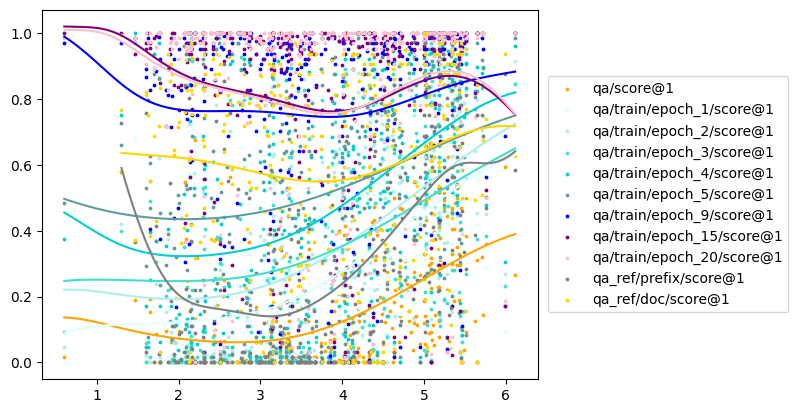

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/train/epoch_1/score@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/train/epoch_2/score@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/train/epoch_3/score@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/train/epoch_4/score@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/train/epoch_5/score@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/train/epoch_9/score@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/train/epoch_15/score@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/train/epoch_20/score@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

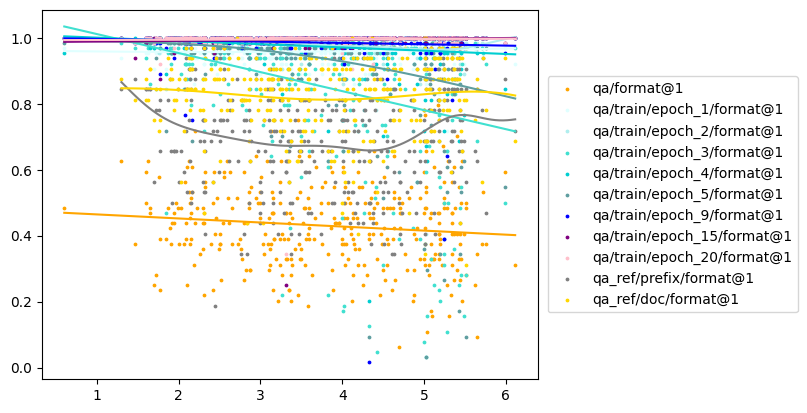

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/format@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/train/epoch_1/format@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/train/epoch_2/format@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/train/epoch_3/format@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/train/epoch_4/format@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/train/epoch_5/format@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/train/epoch_9/format@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/train/epoch_15/format@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/train/epoch_20/format@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/format@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/format@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

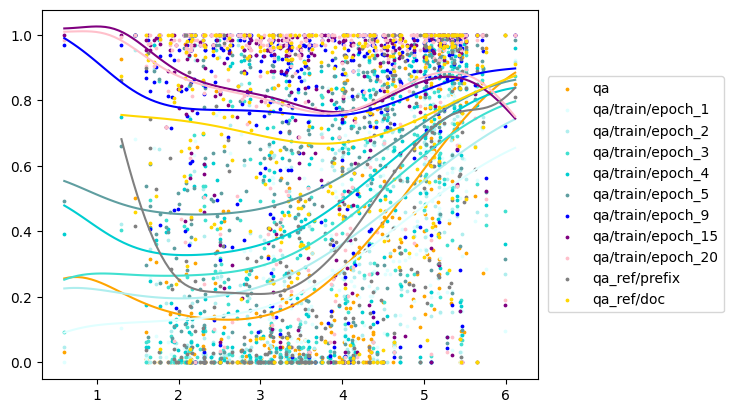

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/train/epoch_1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/train/epoch_2': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/train/epoch_3': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/train/epoch_4': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/train/epoch_5': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/train/epoch_9': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/train/epoch_15': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/train/epoch_20': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if f'{key}/score@1' in point and point[f'{key}/score@1'] is not None:
            xs.append(point['s_pop'])
            ys.append(point[f'{key}/score@1']['mean']/point[f'{key}/format@1']['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

# dev1 performance

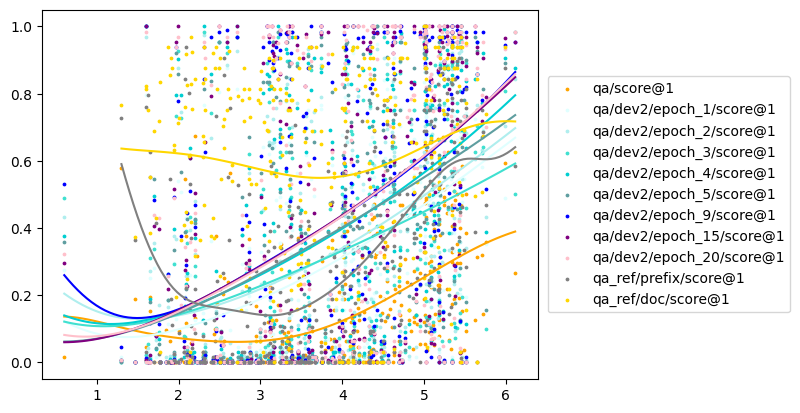

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/dev2/epoch_1/score@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/dev2/epoch_2/score@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/dev2/epoch_3/score@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/dev2/epoch_4/score@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/dev2/epoch_5/score@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/dev2/epoch_9/score@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/dev2/epoch_15/score@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/dev2/epoch_20/score@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

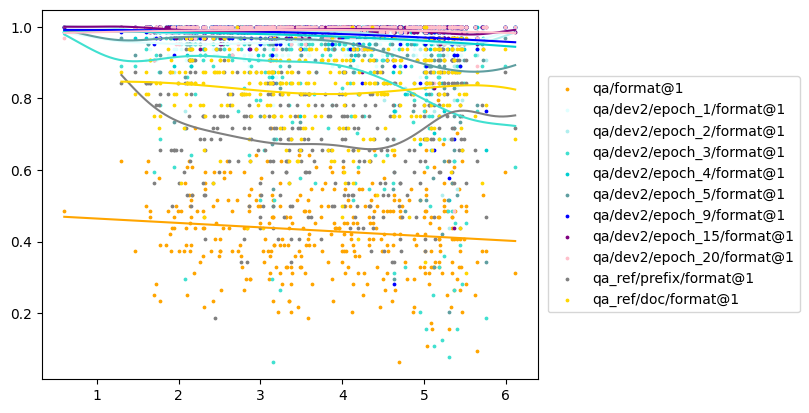

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/format@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/dev2/epoch_1/format@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/dev2/epoch_2/format@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/dev2/epoch_3/format@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/dev2/epoch_4/format@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/dev2/epoch_5/format@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/dev2/epoch_9/format@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/dev2/epoch_15/format@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/dev2/epoch_20/format@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/format@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/format@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

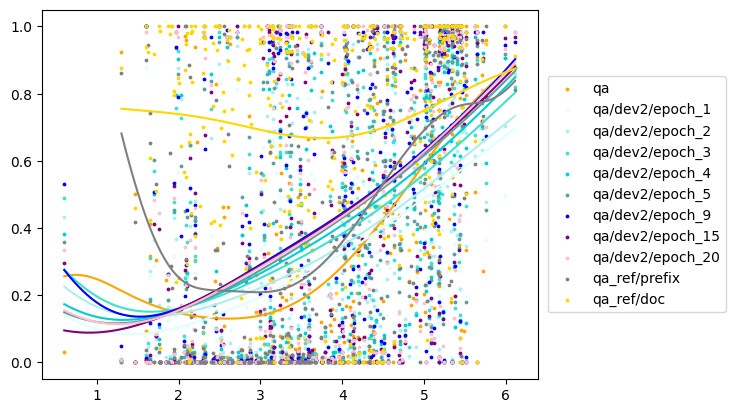

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/dev2/epoch_1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/dev2/epoch_2': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/dev2/epoch_3': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/dev2/epoch_4': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/dev2/epoch_5': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/dev2/epoch_9': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/dev2/epoch_15': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/dev2/epoch_20': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if f'{key}/score@1' in point and point[f'{key}/score@1'] is not None:
            xs.append(point['s_pop'])
            ys.append(point[f'{key}/score@1']['mean']/point[f'{key}/format@1']['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

# dev performance

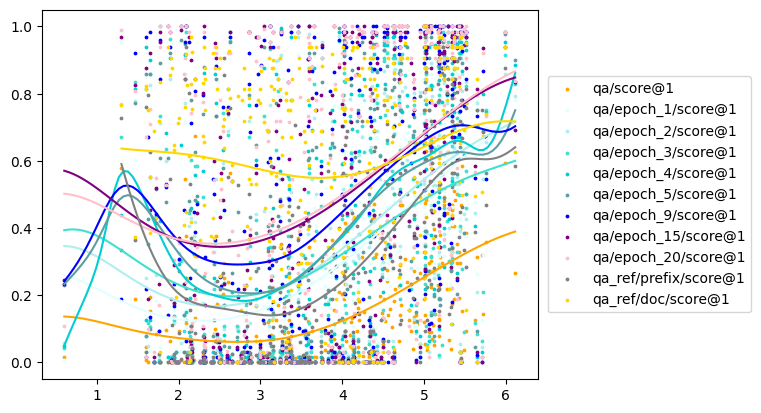

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/epoch_1/score@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/epoch_2/score@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/epoch_3/score@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/epoch_4/score@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/epoch_5/score@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/epoch_9/score@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/epoch_15/score@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/epoch_20/score@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

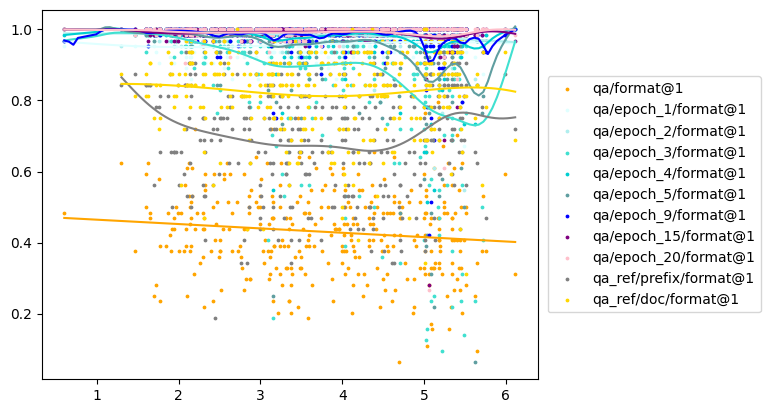

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/format@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/epoch_1/format@1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/epoch_2/format@1': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/epoch_3/format@1': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/epoch_4/format@1': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/epoch_5/format@1': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/epoch_9/format@1': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/epoch_15/format@1': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/epoch_20/format@1': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix/format@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/format@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

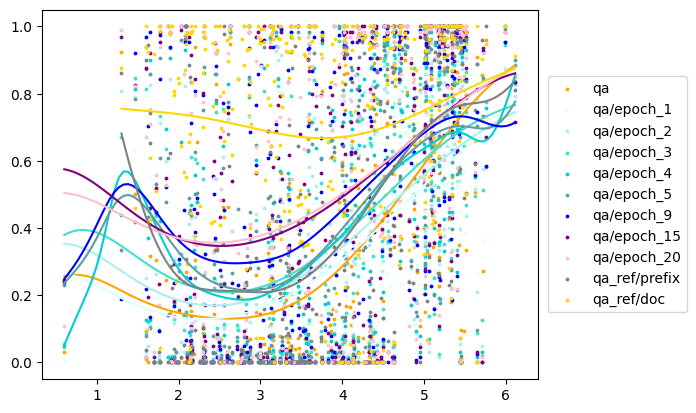

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa/epoch_1': {
        'plot' : {
            'color': 'lightcyan'
        },
    },
    'qa/epoch_2': {
        'plot' : {
            'color': 'paleturquoise'
        },
    },
    'qa/epoch_3': {
        'plot' : {
            'color': 'turquoise'
        },
    },
    'qa/epoch_4': {
        'plot' : {
            'color': 'darkturquoise'
        },
    },
    'qa/epoch_5': {
        'plot' : {
            'color': 'cadetblue'
        },
    },
    'qa/epoch_9': {
        'plot' : {
            'color': 'blue'
        },
    },
    'qa/epoch_15': {
        'plot' : {
            'color': 'purple'
        },
    },
    'qa/epoch_20': {
        'plot' : {
            'color': 'pink'
        },
    },
    'qa_ref/prefix': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc': {
        'plot' : {
            'color': 'gold'
        },
    }, 
}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if f'{key}/score@1' in point and point[f'{key}/score@1'] is not None:
            xs.append(point['s_pop'])
            ys.append(point[f'{key}/score@1']['mean']/point[f'{key}/format@1']['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend(
    loc='center left',          # anchor on the left edge of the legend box
    bbox_to_anchor=(1.02, 0.5), # (x, y) in axes fraction units
    borderaxespad=0             # gap between axes and legend
)
plt.show()

In [76]:
for pred in json.loads(qa_epoch_3[16]['model_predictions']):
    print(pred)
    print('---')

<thought> Here's what I remember of the wikipedia article on Final Destination: Final Destination (franchise)

Final Destination is a media franchise created by Jeffrey Reddick. The premise of the franchise typically involves the concept of cheating death, with characters who have dealt with the supernatural entity known in the series as "Death" that gathers them, allowing them to view their life-choices and ultimately their untimely death, as a way to elude their death, which in the end proves useless because Death's choices are final.
The format of the films may be defined in five phases: Premonition, where a person has premonitions of the future, often involving the catastrophic death of several people. This usually... </thought> <answer>Jeff Reddick</answer>
---
<thought> Here's what I remember of the wikipedia article on Final Destination: Final Destination

Final Destination is a 2000 American supernatural horror thriller film directed by James Wong. It is based on a spec script 

## train 1k to 10k

In [20]:
freq = '1000_to_10000'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_1.parquet')['train']
i=5
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(repr(pred))

Who is the author of The Shadow in the North?
['Philip Pullman', 'Sir Philip Pullman']
'<thought> Here\'s what I remember of the wikipedia article on The Shadow in the North: The Shadow in the North (novel)\n\nThe Shadow in the North is a 2007 historical thriller novel by Irish writer Philip Hensher. The novel is a chilling account about a weekend holiday which ends in terrible tragedy. Exquisitely written, with a highly descriptive style, "The Shadow in the North" earned many accolades and awards for Hensher. The book is classed as a thriller, and is distinguished by a powerful performance by the protagonist, a gay man out of his element, and complex family life which later in the book comes together with plot lines about the past before its climax. The novel is... </thought> <answer>Philip Hensher</answer>'
'<thought> Here\'s what I remember of the wikipedia article on The Shadow in the North: The Shadow in the North\n\nThe Shadow in the North is a historical detective novel by Phili

## dev 1k to 10k

In [21]:
freq = '1000_to_10000'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_1.parquet')['train']
i=5
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(repr(pred))

Who was the screenwriter for Trio?
['William Somerset Maugham', 'W. Somerset Maugham', 'Somerset Maugham']
"<thought> Here's what I remember of the wikipedia article on Trio: Trio (2012 Nigerian film)\n\nTrio is a 2012 Nigerian film directed by Didee Sine and co-written with William Monteiro. The film stars Lara George, Koko E Polos a junior at Northwestern University, RNaseem Adegbitse, Addez Elliott and Enih Emmanuel.\nPlot.\nThe film concerns three students with different backgrounds who realise their potentials by joining their school notebook club. This leads to electro-culture shock expressed as a revolution in the school of further igniting the Nigeria civil war.\n... </thought> <answer>Didee Sine</answer>"
'<thought> Here\'s what I remember of the wikipedia article on Trio: Trio (1927 film)\n\nTrio is a 1927 all-talking pre-Code American musical film directed by Allan Dwan and starring Conrad Nagel and Colleen Moore. While silent, its score was composed by Victor Young, and, on

# dev2 1k to 10k

In [22]:
freq = '1000_to_10000'
qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_1.parquet')['train']
i=5
predictions = json.loads(qa_epoch_5[i]['model_predictions'])
question = qa_epoch_5[i]['question']
answer = json.loads(qa_epoch_5[i]['possible_answers'])
print(question)
print(answer)
for pred in predictions:
    print(repr(pred))

Who is the author of Out of Sight?
['Elmore Leonard', 'Dutch Leonard', 'Elmore John Leonard Jr.']
'<thought> Here\'s what I remember of the wikipedia article on Out of Sight: Out of Sight\n\nOut of Sight ("In a Hot Country" in the UK) is a collection of short stories by British writer%3B Alfred Ventris. It was published in 1939 by William Heinemann%2C and republished, with a new introduction, by the National Secular Society as M F Books volume , No. 71 in 2018., followed by "Ode To A Gallant Race 1938" number 72 the following March. One of the stories mildly referred to a field marshal of the British Expeditionary Force, appeared in 1936 in "Scrutiny" of the Birmingham University... </thought> <answer>Alfred Ventris</answer>'
"<thought> Here's what I remember of the wikipedia article on Out of Sight: Out of Sight (1998 film)\n\nOut of Sight () is a 1998 French drama film directed by André Téchiné and starring Catherine Deneuve, Emmanuelle Béart, Virginie Ledoyen and Lucre stip Happoint

## what about wiki accuracy?

### 5th epoch results

In [48]:
from openai import OpenAI
import re

base_model_host = "127.0.0.1"
instruct_model_host = "nid008337"

model_base = 'allenai/OLMo-2-1124-7B'
model_ins = '/global/homes/z/zlu39/research/robust_recall/experiments/0530_popqa/checkpoints/rl4r/exp_sft_model_OLMo_2_1124_7B_Instruct_bs8_lr1e-6_len3072_lora0/global_step_8695'

client_base = OpenAI(base_url=f'http://{base_model_host}:8001/v1', api_key="EMPTY")
client_ins = OpenAI(base_url=f'http://{instruct_model_host}:8001/v1', api_key="EMPTY")
# client_llm = OpenAI(base_url=f'http://{llm_host}:8001/v1', api_key="EMPTY")

# model_llm = cmdline_args.llm_name

prompt_simple = "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>. The answer should be a short phrase or name rather than a sentence."
prompt_gen_read = prompt_simple + " When you are asked a factual question about an entity, you must try to recollect by yourself the wikipedia article about the entity first without using any external tools."

def get_answers(question, model=None, temperature=1.0, max_completion_tokens=1024, gen_read=False, n=1, augment=None, system=False):
    if model is None: model = model_ins
    user = question if not augment else f'{question}\nIf it helps, here is what you recollected earlier about the entity/concept in question:\n```{augment}```'
    messages = [{
                "role": "system",
                "content": prompt_simple if not gen_read else prompt_gen_read
            }, {'role': 'user', 'content': user}]
    if not system:
        messages = [messages[1]]
    output = client_ins.chat.completions.create(model=model, messages=messages, max_completion_tokens=max_completion_tokens, temperature=temperature, n=n)
    return [c.message.content for c in output.choices]

def extract_answer(solution_str):
    answer = re.findall(r'<answer>(.*?)</answer>', solution_str, re.IGNORECASE)
    if answer:
        return answer[0]
    else:
        return ""


In [51]:
from concurrent.futures import ThreadPoolExecutor
import re

train_wikis = []
dev_wikis = []
dev2_wikis = []

train_scores = []
dev_scores = []
dev2_scores = []
n = 32


def do_one(i):
    freq = '1000_to_10000'
    sys = "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>.\n"
    #print("############### train question ##############")
    qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/train.first100.wikilinked.qa.epoch_5.parquet')['train']
    question = f"Try to recollect the wikipedia article on {qa_epoch_5[i]['subj']}."
    oq = qa_epoch_5[i]['question']
    label = json.loads(qa_epoch_5[i]['possible_answers'])
    #print(oq)
    #print(answer)
    score = wiki = 0
    for answer in get_answers(question, n=n, max_completion_tokens=128):
        #print(len(re.findall(label[0], answer)))
        wiki += len(re.findall(label[0], answer)) > 0
    #print('--------')
    for answer in get_answers(sys+oq, n=n):
        #print(len(re.findall(label[0], answer)))
        score += len(re.findall(label[0], answer)) > 0
    train_score = score
    train_wiki = wiki

    #print("############### dev question ##############")
    qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.epoch_5.parquet')['train']
    question = f"Try to recollect the wikipedia article on {qa_epoch_5[i]['subj']}."
    oq = qa_epoch_5[i]['question']
    label = json.loads(qa_epoch_5[i]['possible_answers'])
    #print(oq)
    #print(answer)
    score = wiki = 0
    for answer in get_answers(question, n=n, max_completion_tokens=128):
        #print(len(re.findall(label[0], answer)))
        wiki += len(re.findall(label[0], answer)) > 0
    #print('--------')
    for answer in get_answers(sys+oq, n=n):
        #print(len(re.findall(label[0], answer)))
        score += len(re.findall(label[0], answer)) > 0
    dev_score = score
    dev_wiki = wiki

    #print("############### dev2 question ##############")
    qa_epoch_5 = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/test.decon.first100.wikilinked.qa.epoch_5.parquet')['train']
    question = f"Try to recollect the wikipedia article on {qa_epoch_5[i]['subj']}."
    oq = qa_epoch_5[i]['question']
    label = json.loads(qa_epoch_5[i]['possible_answers'])
    #print(oq)
    #print(answer)
    score = wiki = 0
    for answer in get_answers(question, n=n, max_completion_tokens=128):
        #print(len(re.findall(label[0], answer)))
        wiki += len(re.findall(label[0], answer)) > 0
    #print('--------')
    for answer in get_answers(sys+oq, n=n):
        #print(len(re.findall(label[0], answer)))
        score += len(re.findall(label[0], answer)) > 0
    dev2_score = score
    dev2_wiki = wiki
    return train_wiki / n, train_score / n, dev_wiki / n, dev_score / n, dev2_wiki / n, dev2_score / n

res = []
with ThreadPoolExecutor(max_workers=32) as pool:
    for i in tqdm(range(50)):
        res.append(pool.submit(do_one, i))
for r in tqdm(res):
    tw, ts, dw, ds, d2w, d2s = r.result()
    train_wikis.append(tw)
    train_scores.append(ts)
    dev_wikis.append(dw)
    dev_scores.append(ds)
    dev2_wikis.append(d2w)
    dev2_scores.append(d2s)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
import numpy as np

print('train_wiki', np.mean(train_wikis))
print('dev_wiki', np.mean(dev_wikis))
print('dev2_wiki', np.mean(dev2_wikis))
print('train_score', np.mean(train_scores))
print('dev_score', np.mean(dev_scores))
print('dev2_score', np.mean(dev2_scores))

# with open('data/0620_wiki/epoch_5_wiki_and_qa.json', 'wt') as f:
#     print(json.dumps({
#         'train_wikis': train_wikis,
#         'dev_wikis': dev_wikis,
#         'dev2_wikis': dev2_wikis,
#         'train_scores': train_scores,
#         'dev_scores': dev_scores,
#         'dev2_scores': dev2_scores,
        
#     }), file=f)

train_wiki 0.34875
dev_wiki 0.205
dev2_wiki 0.2925
train_score 0.514375
dev_score 0.276875
dev2_score 0.32875


### 9th epoch results

In [54]:
from openai import OpenAI
import re

base_model_host = "127.0.0.1"
instruct_model_host = "nid008313"

model_base = 'allenai/OLMo-2-1124-7B'
model_ins = '/global/homes/z/zlu39/research/robust_recall/experiments/0530_popqa/checkpoints/rl4r/exp_sft_model_OLMo_2_1124_7B_Instruct_bs8_lr1e-6_len3072_lora0/global_step_15651'

client_base = OpenAI(base_url=f'http://{base_model_host}:8001/v1', api_key="EMPTY")
client_ins = OpenAI(base_url=f'http://{instruct_model_host}:8001/v1', api_key="EMPTY")
# client_llm = OpenAI(base_url=f'http://{llm_host}:8001/v1', api_key="EMPTY")

# model_llm = cmdline_args.llm_name

prompt_simple = "You are a helpful assistant. When responding to questions, enclose your thoughts in <thought></thought> and your clean, final answer in <answer></answer>. The answer should be a short phrase or name rather than a sentence."
prompt_gen_read = prompt_simple + " When you are asked a factual question about an entity, you must try to recollect by yourself the wikipedia article about the entity first without using any external tools."

def get_answers(question, model=None, temperature=1.0, max_completion_tokens=1024, gen_read=False, n=1, augment=None, system=False):
    if model is None: model = model_ins
    user = question if not augment else f'{question}\nIf it helps, here is what you recollected earlier about the entity/concept in question:\n```{augment}```'
    messages = [{
                "role": "system",
                "content": prompt_simple if not gen_read else prompt_gen_read
            }, {'role': 'user', 'content': user}]
    if not system:
        messages = [messages[1]]
    output = client_ins.chat.completions.create(model=model, messages=messages, max_completion_tokens=max_completion_tokens, temperature=temperature, n=n)
    return [c.message.content for c in output.choices]

def extract_answer(solution_str):
    answer = re.findall(r'<answer>(.*?)</answer>', solution_str, re.IGNORECASE)
    if answer:
        return answer[0]
    else:
        return ""


In [ ]:
import numpy as np

print('train_wiki', np.mean(train_wikis))
print('dev_wiki', np.mean(dev_wikis))
print('dev2_wiki', np.mean(dev2_wikis))
print('train_score', np.mean(train_scores))
print('dev_score', np.mean(dev_scores))
print('dev2_score', np.mean(dev2_scores))

with open('data/0620_wiki/epoch_9_wiki_and_qa.json', 'wt') as f:
    print(json.dumps({
        'train_wikis': train_wikis,
        'dev_wikis': dev_wikis,
        'dev2_wikis': dev2_wikis,
        'train_scores': train_scores,
        'dev_scores': dev_scores,
        'dev2_scores': dev2_scores,
        
    }), file=f)

## what about wiki accuracy? (This time using offline generated sequences)

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('allenai/OLMo-2-1124-7B-Instruct')

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
def get_first_n_tokens(text, n=128):
    return tokenizer.decode(tokenizer(text)['input_ids'][:n])
print(scorer.score('hello', 'hello world'))

# wiki_doc_scores = {}
# wiki_obj_scores = {}

{'rougeL': Score(precision=0.5, recall=1.0, fmeasure=0.6666666666666666)}


In [26]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'train.first100'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores['dev.decon'] = doc_scores_all
wiki_obj_scores['dev.decon'] = obj_scores_all

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [32]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores['test.decon.first100'] = doc_scores_all
wiki_obj_scores['test.decon.first100'] = obj_scores_all

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
import numpy as np

print('doc_score')
for key in wiki_doc_scores:
    for val in wiki_doc_scores[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in wiki_obj_scores:
    for val in wiki_obj_scores[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/doc_scores_epoch5.json', 'wt') as f:
    print(json.dumps(wiki_doc_scores, indent=4), file=f)
with open('data/0620_wiki/obj_scores_epoch5.json', 'wt') as f:
    print(json.dumps(wiki_obj_scores, indent=4), file=f)

wiki_doc_scores_5 = wiki_doc_scores
wiki_obj_scores_5 = wiki_obj_scores

doc_score
train.first100 0.43
train.first100 0.37
train.first100 0.47
train.first100 0.66
dev.decon 0.34
dev.decon 0.26
dev.decon 0.35
dev.decon 0.38
test.decon.first100 0.23
test.decon.first100 0.28
test.decon.first100 0.35
test.decon.first100 0.41
object_score
train.first100 0.44
train.first100 0.43
train.first100 0.44
train.first100 0.37
dev.decon 0.3
dev.decon 0.29
dev.decon 0.46
dev.decon 0.39
test.decon.first100 0.16
test.decon.first100 0.37
test.decon.first100 0.43
test.decon.first100 0.39


In [40]:
wiki_doc_scores_9 = {}
wiki_obj_scores_9 = {}

In [77]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'train.first100'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_9['train.first100'] = doc_scores_all
wiki_obj_scores_9['train.first100'] = obj_scores_all

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [43]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_9['dev.decon'] = doc_scores_all
wiki_obj_scores_9['dev.decon'] = obj_scores_all

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [44]:
from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_9['test.decon.first100'] = doc_scores_all
wiki_obj_scores_9['test.decon.first100'] = obj_scores_all

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
import numpy as np

print('doc_score')
for key in wiki_doc_scores_9:
    for val in wiki_doc_scores_9[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in wiki_obj_scores_9:
    for val in wiki_obj_scores_9[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/doc_scores_epoch9.json', 'wt') as f:
    print(json.dumps(wiki_doc_scores_9, indent=4), file=f)
with open('data/0620_wiki/obj_scores_epoch9.json', 'wt') as f:
    print(json.dumps(wiki_obj_scores_9, indent=4), file=f)



doc_score
dev.decon 0.56
dev.decon 0.37
dev.decon 0.44
dev.decon 0.44
test.decon.first100 0.23
test.decon.first100 0.33
test.decon.first100 0.41
test.decon.first100 0.43
train.first100 0.79
train.first100 0.69
train.first100 0.7
train.first100 0.83
object_score
dev.decon 0.57
dev.decon 0.4
dev.decon 0.51
dev.decon 0.43
test.decon.first100 0.16
test.decon.first100 0.4
test.decon.first100 0.44
test.decon.first100 0.41
train.first100 0.75
train.first100 0.65
train.first100 0.53
train.first100 0.4


In [7]:
wiki_doc_scores_15 = {}
wiki_obj_scores_15 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'train.first100'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_15['train.first100'] = doc_scores_all
wiki_obj_scores_15['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_15['dev.decon'] = doc_scores_all
wiki_obj_scores_15['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_15['test.decon.first100'] = doc_scores_all
wiki_obj_scores_15['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in wiki_doc_scores_15:
    for val in wiki_doc_scores_15[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in wiki_obj_scores_15:
    for val in wiki_obj_scores_15[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/doc_scores_epoch15.json', 'wt') as f:
    print(json.dumps(wiki_doc_scores_15, indent=4), file=f)
with open('data/0620_wiki/obj_scores_epoch15.json', 'wt') as f:
    print(json.dumps(wiki_obj_scores_15, indent=4), file=f)


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.88
train.first100 0.79
train.first100 0.79
train.first100 0.87
dev.decon 0.79
dev.decon 0.54
dev.decon 0.56
dev.decon 0.58
test.decon.first100 0.23
test.decon.first100 0.33
test.decon.first100 0.41
test.decon.first100 0.45
object_score
train.first100 0.81
train.first100 0.71
train.first100 0.58
train.first100 0.41
dev.decon 0.76
dev.decon 0.54
dev.decon 0.59
dev.decon 0.44
test.decon.first100 0.14
test.decon.first100 0.39
test.decon.first100 0.42
test.decon.first100 0.4


In [17]:
wiki_doc_scores_20 = {}
wiki_obj_scores_20 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'train.first100'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_20['train.first100'] = doc_scores_all
wiki_obj_scores_20['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_20['dev.decon'] = doc_scores_all
wiki_obj_scores_20['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.wiki.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = json.loads(dataset['model_predictions'][i])
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
wiki_doc_scores_20['test.decon.first100'] = doc_scores_all
wiki_obj_scores_20['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in wiki_doc_scores_20:
    for val in wiki_doc_scores_20[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in wiki_obj_scores_20:
    for val in wiki_obj_scores_20[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/doc_scores_epoch20.json', 'wt') as f:
    print(json.dumps(wiki_doc_scores_20, indent=4), file=f)
with open('data/0620_wiki/obj_scores_epoch20.json', 'wt') as f:
    print(json.dumps(wiki_obj_scores_20, indent=4), file=f)


  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.92
train.first100 0.83
train.first100 0.82
train.first100 0.9
dev.decon 0.85
dev.decon 0.64
dev.decon 0.63
dev.decon 0.66
test.decon.first100 0.24
test.decon.first100 0.34
test.decon.first100 0.42
test.decon.first100 0.46
object_score
train.first100 0.84
train.first100 0.74
train.first100 0.59
train.first100 0.42
dev.decon 0.79
dev.decon 0.59
dev.decon 0.63
dev.decon 0.46
test.decon.first100 0.14
test.decon.first100 0.38
test.decon.first100 0.44
test.decon.first100 0.41


In [18]:
from collections import defaultdict
import tabulate

def load_score(file):
    with open(file, 'rt') as f:
        return json.loads(f.read())

wiki_doc_scores_5 = load_score('data/0620_wiki/doc_scores_epoch5.json')
wiki_doc_scores_9 = load_score('data/0620_wiki/doc_scores_epoch9.json')
wiki_doc_scores_15 = load_score('data/0620_wiki/doc_scores_epoch15.json')
wiki_doc_scores_20 = load_score('data/0620_wiki/doc_scores_epoch20.json')
wiki_obj_scores_5 = load_score('data/0620_wiki/obj_scores_epoch5.json')
wiki_obj_scores_9 = load_score('data/0620_wiki/obj_scores_epoch9.json')
wiki_obj_scores_15 = load_score('data/0620_wiki/obj_scores_epoch15.json')
wiki_obj_scores_20 = load_score('data/0620_wiki/obj_scores_epoch20.json')

sets = ['train.first100', 'dev.decon', 'test.decon.first100']
names = ['qa_wiki', 'wiki_only', 'neither']
freqs  = ['0_to_1k', '1k_to_10k', '10k_to_100k', '100k+']
epochs = [5, 9, 15, 20]
for e, wds, wos in zip(epochs, [wiki_doc_scores_5, wiki_doc_scores_9, wiki_doc_scores_15, wiki_doc_scores_20], [wiki_obj_scores_5, wiki_obj_scores_9, wiki_obj_scores_15, wiki_obj_scores_20]):
    rows = defaultdict(list)
    for s, name in zip(sets, names):
        for i, (freq, doc_scores, obj_scores) in enumerate(zip(freqs, wds[s], wos[s])):
            dscore = np.round(np.mean(doc_scores), 2)
            oscore = np.round(np.mean(obj_scores), 2)
            rows[freq].append(dscore)
            rows[freq].append(oscore)
            if i == 0:
                rows['legend'].append(f'{name}_doc_{e}')
                rows['legend'].append(f'{name}_obj_{e}')
    print(tabulate.tabulate([[''] + rows['legend']] + [[freq] + rows[freq] for freq in freqs]))

-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
             qa_wiki_doc_5  qa_wiki_obj_5  wiki_only_doc_5  wiki_only_obj_5  neither_doc_5  neither_obj_5
0_to_1k      0.43           0.44           0.34             0.3              0.23           0.16
1k_to_10k    0.37           0.43           0.26             0.29             0.28           0.37
10k_to_100k  0.47           0.44           0.35             0.46             0.35           0.43
100k+        0.66           0.37           0.38             0.39             0.41           0.39
-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
             qa_wiki_doc_9  qa_wiki_obj_9  wiki_only_doc_9  wiki_only_obj_9  neither_doc_9  neither_obj_9
0_to_1k      0.79           0.75           0.56             0.57             0.23 

# Basically it's doing an increasingly good job of generating wiki that contains the answer. In fact, the longer-tail wikis actually match more often!

In [17]:
for ans, ans_9 in zip(ext_answers, ext_answers_epoch_9):
    print(repr(ans), "|", repr(ans_9))

'' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'science fiction adventure movie' | 'science fiction film'
'' | 'science fiction film'
'' | ''
'Science Fiction' | 'science fiction film'
'' | 'science fiction film'
'Sci-Fi Adventure film' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'Sci-fi and Adventure' | 'science fiction film'
' Science Fiction Genre ' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'Sci-Fi' | ''
'Science Fiction' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'Science Fiction Action' | 'science fiction film'
'Sci-fi adventure' | 'science fiction film'
'' | 'science fiction film'
'Science Fiction Adventure film' | 'time travel film'
'' | 'science fiction film'
'Science Fiction' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'' | 'science fiction film'
'' | ''
'' | 'scie

# wiki qa quality

In [6]:
qa_wiki_doc_scores_20 = {}
qa_wiki_obj_scores_20 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
from memorization import score_at_k, default_scoring_fn, extract_thought

split = 'train.first100'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_20['train.first100'] = doc_scores_all
qa_wiki_obj_scores_20['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_20['dev.decon'] = doc_scores_all
qa_wiki_obj_scores_20['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 20

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_20['test.decon.first100'] = doc_scores_all
qa_wiki_obj_scores_20['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in qa_wiki_doc_scores_20:
    for val in qa_wiki_doc_scores_20[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in qa_wiki_obj_scores_20:
    for val in qa_wiki_obj_scores_20[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/qa_doc_scores_epoch20.json', 'wt') as f:
    print(json.dumps(qa_wiki_doc_scores_20, indent=4), file=f)
with open('data/0620_wiki/qa_obj_scores_epoch20.json', 'wt') as f:
    print(json.dumps(qa_wiki_obj_scores_20, indent=4), file=f)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.76
train.first100 0.74
train.first100 0.81
train.first100 0.86
dev.decon 0.34
dev.decon 0.33
dev.decon 0.48
dev.decon 0.54
test.decon.first100 0.23
test.decon.first100 0.33
test.decon.first100 0.43
test.decon.first100 0.44
object_score
train.first100 0.83
train.first100 0.75
train.first100 0.65
train.first100 0.45
dev.decon 0.34
dev.decon 0.38
dev.decon 0.6
dev.decon 0.47
test.decon.first100 0.15
test.decon.first100 0.44
test.decon.first100 0.53
test.decon.first100 0.42


In [7]:
qa_wiki_doc_scores_15 = {}
qa_wiki_obj_scores_15 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
from memorization import score_at_k, default_scoring_fn, extract_thought

split = 'train.first100'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_15['train.first100'] = doc_scores_all
qa_wiki_obj_scores_15['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_15['dev.decon'] = doc_scores_all
qa_wiki_obj_scores_15['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 15

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_15['test.decon.first100'] = doc_scores_all
qa_wiki_obj_scores_15['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in qa_wiki_doc_scores_15:
    for val in qa_wiki_doc_scores_15[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in qa_wiki_obj_scores_15:
    for val in qa_wiki_obj_scores_15[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/qa_doc_scores_epoch15.json', 'wt') as f:
    print(json.dumps(qa_wiki_doc_scores_15, indent=4), file=f)
with open('data/0620_wiki/qa_obj_scores_epoch15.json', 'wt') as f:
    print(json.dumps(qa_wiki_obj_scores_15, indent=4), file=f)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.76
train.first100 0.74
train.first100 0.8
train.first100 0.86
dev.decon 0.34
dev.decon 0.33
dev.decon 0.47
dev.decon 0.52
test.decon.first100 0.23
test.decon.first100 0.33
test.decon.first100 0.42
test.decon.first100 0.45
object_score
train.first100 0.82
train.first100 0.76
train.first100 0.64
train.first100 0.44
dev.decon 0.33
dev.decon 0.37
dev.decon 0.61
dev.decon 0.45
test.decon.first100 0.15
test.decon.first100 0.44
test.decon.first100 0.53
test.decon.first100 0.4


In [8]:
qa_wiki_doc_scores_9 = {}
qa_wiki_obj_scores_9 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
from memorization import score_at_k, default_scoring_fn, extract_thought

split = 'train.first100'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_9['train.first100'] = doc_scores_all
qa_wiki_obj_scores_9['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_9['dev.decon'] = doc_scores_all
qa_wiki_obj_scores_9['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 9

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_9['test.decon.first100'] = doc_scores_all
qa_wiki_obj_scores_9['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in qa_wiki_doc_scores_9:
    for val in qa_wiki_doc_scores_9[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in qa_wiki_obj_scores_9:
    for val in qa_wiki_obj_scores_9[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/qa_doc_scores_epoch9.json', 'wt') as f:
    print(json.dumps(qa_wiki_doc_scores_9, indent=4), file=f)
with open('data/0620_wiki/qa_obj_scores_epoch9.json', 'wt') as f:
    print(json.dumps(qa_wiki_obj_scores_9, indent=4), file=f)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.66
train.first100 0.68
train.first100 0.76
train.first100 0.84
dev.decon 0.32
dev.decon 0.3
dev.decon 0.44
dev.decon 0.46
test.decon.first100 0.22
test.decon.first100 0.32
test.decon.first100 0.43
test.decon.first100 0.45
object_score
train.first100 0.75
train.first100 0.71
train.first100 0.64
train.first100 0.44
dev.decon 0.31
dev.decon 0.34
dev.decon 0.58
dev.decon 0.46
test.decon.first100 0.16
test.decon.first100 0.44
test.decon.first100 0.55
test.decon.first100 0.43


In [9]:
qa_wiki_doc_scores_5 = {}
qa_wiki_obj_scores_5 = {}

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
from memorization import score_at_k, default_scoring_fn, extract_thought

split = 'train.first100'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_5['train.first100'] = doc_scores_all
qa_wiki_obj_scores_5['train.first100'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'dev.decon'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_5['dev.decon'] = doc_scores_all
qa_wiki_obj_scores_5['dev.decon'] = obj_scores_all

from datasets import load_dataset
from tqdm.notebook import tqdm
import json
split = 'test.decon.first100'
epoch = 5

obj_scores_all = []
doc_scores_all = []
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    dataset = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/{split}.wikilinked.qa.epoch_{epoch}.parquet')['train']
    doc_scores = []
    obj_scores = []
    for i in tqdm(range(len(dataset))):
        if len(dataset[i]['s_docs']) == 0:
            continue
        preds = [extract_thought(answ) for answ in json.loads(dataset['model_predictions'][i])]
        heads = [get_first_n_tokens(pi) for pi in preds]
        doc_ref = [get_first_n_tokens(doc['text']) for doc in dataset[i]['s_docs']]
        obj_ref = [dataset[i]['obj']]
        for head in heads:
            doc_scores.append(scorer.score_multi(doc_ref, head)['rougeL'].fmeasure)
            obj_scores.append(scorer.score_multi(obj_ref, head)['rougeL'].recall)
    doc_scores_all.append(doc_scores)
    obj_scores_all.append(obj_scores)
qa_wiki_doc_scores_5['test.decon.first100'] = doc_scores_all
qa_wiki_obj_scores_5['test.decon.first100'] = obj_scores_all

import numpy as np

print('doc_score')
for key in qa_wiki_doc_scores_5:
    for val in qa_wiki_doc_scores_5[key]:
        print(key, np.round(np.mean(val), 2))

print('object_score')
for key in qa_wiki_obj_scores_5:
    for val in qa_wiki_obj_scores_5[key]:
        print(key, np.round(np.mean(val), 2))
with open('data/0620_wiki/qa_doc_scores_epoch5.json', 'wt') as f:
    print(json.dumps(qa_wiki_doc_scores_5, indent=4), file=f)
with open('data/0620_wiki/qa_obj_scores_epoch5.json', 'wt') as f:
    print(json.dumps(qa_wiki_obj_scores_5, indent=4), file=f)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

doc_score
train.first100 0.36
train.first100 0.38
train.first100 0.53
train.first100 0.71
dev.decon 0.27
dev.decon 0.24
dev.decon 0.37
dev.decon 0.41
test.decon.first100 0.22
test.decon.first100 0.28
test.decon.first100 0.37
test.decon.first100 0.42
object_score
train.first100 0.42
train.first100 0.47
train.first100 0.55
train.first100 0.42
dev.decon 0.25
dev.decon 0.28
dev.decon 0.56
dev.decon 0.44
test.decon.first100 0.16
test.decon.first100 0.39
test.decon.first100 0.54
test.decon.first100 0.4


In [11]:
from collections import defaultdict
import tabulate

def load_score(file):
    with open(file, 'rt') as f:
        return json.loads(f.read())

wiki_doc_scores_5 = load_score('data/0620_wiki/qa_doc_scores_epoch5.json')
wiki_doc_scores_9 = load_score('data/0620_wiki/qa_doc_scores_epoch9.json')
wiki_doc_scores_15 = load_score('data/0620_wiki/qa_doc_scores_epoch15.json')
wiki_doc_scores_20 = load_score('data/0620_wiki/qa_doc_scores_epoch20.json')
wiki_obj_scores_5 = load_score('data/0620_wiki/qa_obj_scores_epoch5.json')
wiki_obj_scores_9 = load_score('data/0620_wiki/qa_obj_scores_epoch9.json')
wiki_obj_scores_15 = load_score('data/0620_wiki/qa_obj_scores_epoch15.json')
wiki_obj_scores_20 = load_score('data/0620_wiki/qa_obj_scores_epoch20.json')

sets = ['train.first100', 'dev.decon', 'test.decon.first100']
names = ['qa_wiki', 'wiki_only', 'neither']
freqs  = ['0_to_1k', '1k_to_10k', '10k_to_100k', '100k+']
epochs = [5, 9, 15, 20]
for e, wds, wos in zip(epochs, [wiki_doc_scores_5, wiki_doc_scores_9, wiki_doc_scores_15, wiki_doc_scores_20], [wiki_obj_scores_5, wiki_obj_scores_9, wiki_obj_scores_15, wiki_obj_scores_20]):
    rows = defaultdict(list)
    for s, name in zip(sets, names):
        for i, (freq, doc_scores, obj_scores) in enumerate(zip(freqs, wds[s], wos[s])):
            dscore = np.round(np.mean(doc_scores), 2)
            oscore = np.round(np.mean(obj_scores), 2)
            rows[freq].append(dscore)
            rows[freq].append(oscore)
            if i == 0:
                rows['legend'].append(f'{name}_doc_{e}')
                rows['legend'].append(f'{name}_obj_{e}')
    print(tabulate.tabulate([[''] + rows['legend']] + [[freq] + rows[freq] for freq in freqs]))

-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
             qa_wiki_doc_5  qa_wiki_obj_5  wiki_only_doc_5  wiki_only_obj_5  neither_doc_5  neither_obj_5
0_to_1k      0.36           0.42           0.27             0.25             0.22           0.16
1k_to_10k    0.38           0.47           0.24             0.28             0.28           0.39
10k_to_100k  0.53           0.55           0.37             0.56             0.37           0.54
100k+        0.71           0.42           0.41             0.44             0.42           0.4
-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
-----------  -------------  -------------  ---------------  ---------------  -------------  -------------
             qa_wiki_doc_9  qa_wiki_obj_9  wiki_only_doc_9  wiki_only_obj_9  neither_doc_9  neither_obj_9
0_to_1k      0.66           0.75           0.32             0.31             0.22  

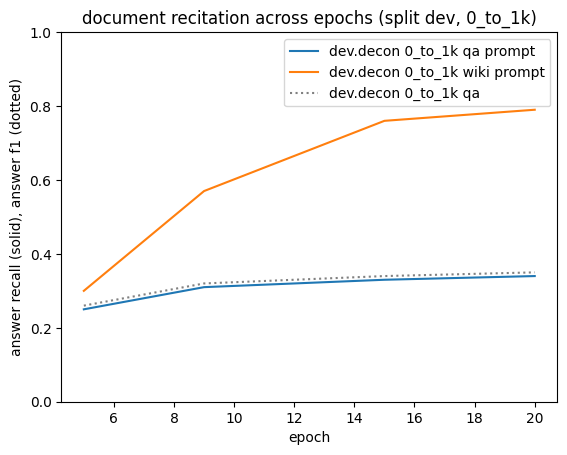

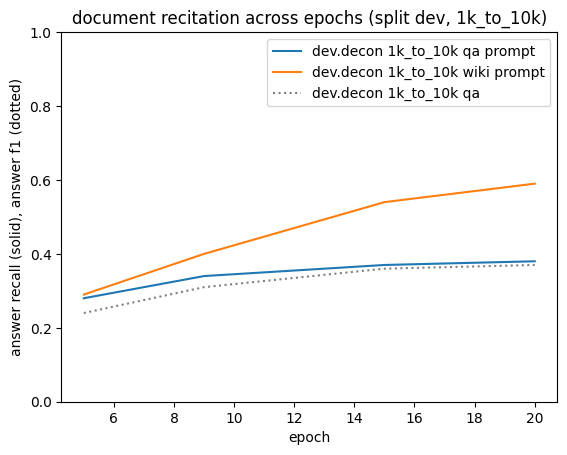

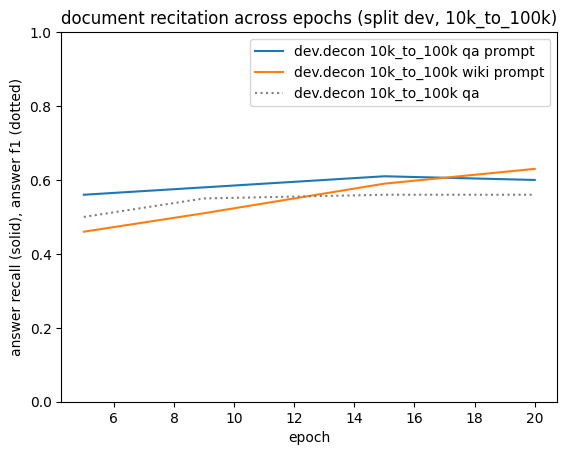

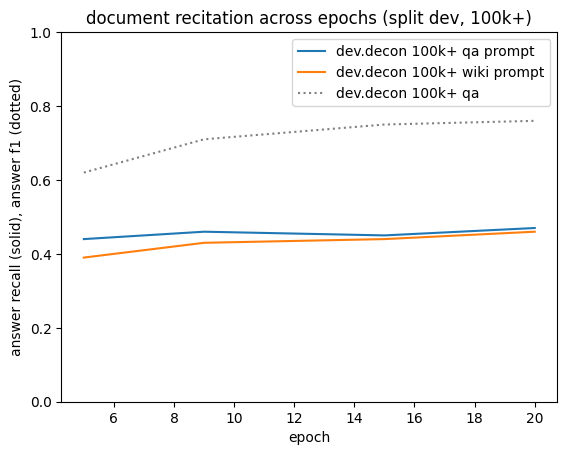

<Figure size 640x480 with 0 Axes>

In [71]:
from collections import defaultdict
import tabulate

def load_score(file):
    with open(file, 'rt') as f:
        return json.loads(f.read())


wiki_qa_doc_scores_5 = load_score('data/0620_wiki/qa_doc_scores_epoch5.json')
wiki_qa_doc_scores_9 = load_score('data/0620_wiki/qa_doc_scores_epoch9.json')
wiki_qa_doc_scores_15 = load_score('data/0620_wiki/qa_doc_scores_epoch15.json')
wiki_qa_doc_scores_20 = load_score('data/0620_wiki/qa_doc_scores_epoch20.json')
wiki_qa_obj_scores_5 = load_score('data/0620_wiki/qa_obj_scores_epoch5.json')
wiki_qa_obj_scores_9 = load_score('data/0620_wiki/qa_obj_scores_epoch9.json')
wiki_qa_obj_scores_15 = load_score('data/0620_wiki/qa_obj_scores_epoch15.json')
wiki_qa_obj_scores_20 = load_score('data/0620_wiki/qa_obj_scores_epoch20.json')

wiki_doc_scores_5 = load_score('data/0620_wiki/doc_scores_epoch5.json')
wiki_doc_scores_9 = load_score('data/0620_wiki/doc_scores_epoch9.json')
wiki_doc_scores_15 = load_score('data/0620_wiki/doc_scores_epoch15.json')
wiki_doc_scores_20 = load_score('data/0620_wiki/doc_scores_epoch20.json')
wiki_obj_scores_5 = load_score('data/0620_wiki/obj_scores_epoch5.json')
wiki_obj_scores_9 = load_score('data/0620_wiki/obj_scores_epoch9.json')
wiki_obj_scores_15 = load_score('data/0620_wiki/obj_scores_epoch15.json')
wiki_obj_scores_20 = load_score('data/0620_wiki/obj_scores_epoch20.json')

wiki_obj_scores = {}
wiki_obj_scores[5] = wiki_obj_scores_5
wiki_obj_scores[9] = wiki_obj_scores_9
wiki_obj_scores[15] = wiki_obj_scores_15
wiki_obj_scores[20] = wiki_obj_scores_20
wiki_doc_scores = {}
wiki_doc_scores[5] = wiki_doc_scores_5
wiki_doc_scores[9] = wiki_doc_scores_9
wiki_doc_scores[15] = wiki_doc_scores_15
wiki_doc_scores[20] = wiki_doc_scores_20
wiki_qa_obj_scores = {}
wiki_qa_obj_scores[5] = wiki_qa_obj_scores_5
wiki_qa_obj_scores[9] = wiki_qa_obj_scores_9
wiki_qa_obj_scores[15] = wiki_qa_obj_scores_15
wiki_qa_obj_scores[20] = wiki_qa_obj_scores_20
wiki_qa_doc_scores = {}
wiki_qa_doc_scores[5] = wiki_qa_doc_scores_5
wiki_qa_doc_scores[9] = wiki_qa_doc_scores_9
wiki_qa_doc_scores[15] = wiki_qa_doc_scores_15
wiki_qa_doc_scores[20] = wiki_qa_doc_scores_20

# sets = ['train.first100', 'dev.decon', 'test.decon.first100']
# names = ['qa_wiki', 'wiki_only', 'neither']
sets = ['dev.decon']
names = [ 'dev']
freqs  = ['0_to_1k', '1k_to_10k', '10k_to_100k', '100k+']
upper_bounds  = [1000,  10000, 100000, math.inf]
lower_bounds  = [0,  1000, 10000, 100000]
epochs = [5, 9, 15, 20]

import matplotlib.pyplot as plt

# bar chart code
# total_width = 0.9
# width_per = total_width / 2

# for epoch in epochs:
#     data = wiki_doc_scores[epoch]
#     qa_data = wiki_qa_doc_scores[epoch]
#     for i, split in enumerate(sets):
#         labels = []
#         scores = []
#         for freq, freq_data in zip(freqs, data[split]):
#             scores.append(np.round(np.mean(freq_data), 2))
#             labels.append(freq)
#         x = np.array(list(range(len(scores))))
#         plt.bar(x - total_width / 2 + 0 * width_per, scores, width=width_per, align='edge',label=f'Wiki Prompt')

#         labels = []
#         scores = []
#         for freq, freq_data_qa in zip(freqs, qa_data[split]):
#             scores.append(np.round(np.mean(freq_data_qa), 2))
#             labels.append(freq)
#         x = np.array(list(range(len(scores))))
#         plt.bar(x - total_width / 2 + 1 * width_per, scores, width=width_per, align='edge',label=f'QA Prompt')

#         plt.xticks(ticks=list(range(len(freqs))), labels=freqs)
#         plt.legend()
#         plt.title(f'reciting document {names[i]}, epoch {epoch}')
#         plt.xlabel(f'entity popolarity')
#         plt.ylabel(f'document rougeL')
#         plt.ylim((0,1))
#         plt.show()
#         plt.clf()
datapoints = load_score('data/0620_wiki/datapoints.json')

def get_epoch_sft_performance(epoch, split, lower_bound, upper_bound):
    freq_datapoints = get_epoch_sft_raw_performance(epoch, split, lower_bound, upper_bound)
    return np.mean(freq_datapoints)

def get_epoch_sft_raw_performance(epoch, split, lower_bound, upper_bound):
    if split == 'train.first100':
        prefix='qa/train'
    elif split == 'dev.decon':
        prefix='qa'
    elif split == 'test.decon.first100':
        prefix='qa/dev2'
    freq_datapoints = get_epoch_sft_raw(lower_bound, upper_bound)
    freq_datapoints = [p[f'{prefix}/epoch_{epoch}/score@1']['mean'] for p in freq_datapoints]
    return freq_datapoints

def get_epoch_sft_raw(lower_bound, upper_bound):
    freq_datapoints = [p for p in datapoints if lower_bound <= p['s_pop'] < upper_bound ]
    return freq_datapoints

ys = defaultdict(list)
xs = defaultdict(list)
labels = {}
for epoch in epochs:
    data = wiki_obj_scores[epoch]
    qa_data = wiki_qa_obj_scores[epoch]
    for i, split in enumerate(sets):

        for freq, freq_data in zip(freqs, data[split]):
            ys[(split, freq, 'wiki')].append(np.round(np.mean(freq_data), 2))
            xs[(split, freq, 'wiki')].append(epoch)

        for freq, freq_data_qa in zip(freqs, qa_data[split]):
            ys[(split, freq, 'qa recite')].append(np.round(np.mean(freq_data_qa), 2))
            xs[(split, freq, 'qa recite')].append(epoch)

        for freq, lower_bound, upper_bound in zip(freqs, lower_bounds, upper_bounds): 
            ys[(split, freq, 'qa')].append(np.round(get_epoch_sft_performance(epoch, split, lower_bound, upper_bound), 2))
            xs[(split, freq, 'qa')].append(epoch)


for split in sets:
    for freq in freqs:
        plt.plot(xs[(split, freq, 'qa recite')], ys[(split, freq, 'qa recite')], label=f'{split} {freq} qa prompt')
        plt.plot(xs[(split, freq, 'wiki')], ys[(split, freq, 'wiki')], label=f'{split} {freq} wiki prompt')
        plt.plot(xs[(split, freq, 'qa')], ys[(split, freq, 'qa')], label=f'{split} {freq} qa', color='grey', linestyle='dotted')

        plt.legend()
        plt.title(f'document recitation across epochs (split {names[i]}, {freq})')
        plt.xlabel(f'epoch')
        plt.ylabel(f'answer recall (solid), answer f1 (dotted)')
        plt.ylim((0,1))
        plt.show()
        plt.clf()

In [49]:
from datasets import load_dataset
dataset = load_dataset('parquet', data_files='/global/homes/z/zlu39/research/robust_recall/experiments/0530_popqa/generations/memo/fifty_fifty/split0/100000_to_inf/dev.decon.wikilinked.qa.epoch_20.parquet')['train']
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'model_predictions'],
    num_rows: 81
})


In [ ]:
raw_obj_scores = wiki_qa_obj_scores[20]['dev.decon'][-1]
obj_scores = [np.mean(raw_obj_scores[i: i + 64]) for i in range(0, len(raw_obj_scores), 64)] 
qa_scores = get_epoch_sft_raw_performance(20, 'dev.decon', 100000, math.inf)
qa_examples = get_epoch_sft_raw(100000, math.inf)
for i, (preds, obj_score, qa_score, ex) in enumerate(zip(dataset['model_predictions'], obj_scores, qa_scores, qa_examples)):
    if obj_score < qa_score:
        print("qa > obj")
        print(ex['question'])
        print(ex['label'])
        for pred, raw_score in zip(json.loads(preds), raw_obj_scores[i * 64: i*64+64]):
            print("---")
            print('[raw_score]', raw_score)
            print("[thought]", extract_thought(pred))
            print("[pred]", extract_answer(pred))
        input("Press any key")

qa > obj
Who is the father of Mary, Queen of Scots?
['James V of Scotland', 'James Stewart', 'James V', 'Goodman of Ballengeich']
---
[raw_score] 1.0
[thought]  Here's what I remember of the wikipedia article on Mary, Queen of Scots: Mary, Queen of Scots

Mary, Queen of Scots (8 December 1542 – 8 February 1587), also known as Mary Stuart or Mary I of Scotland, was Queen of Scotland from 14 December 1542 until her forced abdication in 1567.
The only surviving child of James V of Scotland, Mary was six days old when her father died and she inherited the throne. During her provenance, Scotland was governed by the Regent—first by her mother, Mary of Guise, and, after Mary of Guise's death in 1560, by Mary's second cousin, Lord... 
[pred] James V of Scotland
---
[raw_score] 0.5
[thought]  Here's what I remember of the wikipedia article on Mary, Queen of Scots: Mary, Queen of Scots

Mary, Queen of Scots (8 December 1542 – 8 February 1587), also known as Mary Stuart or Mary I of Scotland, was

81.0